# Portfolio Manager

## Dependencies

In [1]:
import requests
import json
import numpy as np
import cvxopt.solvers
import datetime
from dateutil.relativedelta import *
from forex_python.converter import CurrencyRates

In [2]:
cvxopt.solvers.options['show_progress'] = False

## Server API implementation

In [38]:
class server_api:
    def __init__(self, user='', pwd=''):
        self.url = 'https://dolphin.jump-technology.com:3389/api/v1/'
        self.s = requests.Session()
        self.s.auth = (user, pwd)
        self.s.headers.update({'x-test': 'true'})
    def expand_params(self, req, params):
        request = ''
        if type(params) is tuple:
            request = self.url + (req.format(*params))
        else:
            request = self.url + (req.format(params))
        return request
    def get(self, req, params):
        request = self.expand_params(req, params)
        self.res = ''
        try:
            self.data = self.s.get(request, headers={'x-test2': 'true'}, verify=False)
            self.res = json.loads(self.data.text)
        except:
            print('Error while connecting')
        return self.res
    def post(self, req, params, body):
        request = self.expand_params(req, params)
        self.res = ''
        try:
            self.data = self.s.post(url=request, data=json.dumps(body), headers={'x-test2': 'true'}, verify=False)
            self.res = json.loads(self.data.text)
        except Exception as err:
            print(err)
            print('Error while connecting')
        return self.res
    def put(self, req, params, body):
        request = self.expand_params(req, params)
        self.res = ''
        print('req', request)
        try:
            self.data = self.s.put(url=request, data=json.dumps(body), headers={'x-test2': 'true'}, verify=False)
            if len(self.data.text) > 0:
                self.res = json.loads(self.data.text)
        except Exception as err:
            print(err)
            print('Error while connecting')
        return self.res
    def get_cached(self):
        return self.res

In [40]:
server = server_api('epita_user_7', 'dolphin19423')

## Portfolio Manager implementation

In [5]:
class portfolio_manager:
    def __init__(self, date_begin, date_end, nb_assets=20, all_currencies=False):
        print('Getting all assets...')
        self.all_assets = server.get('asset', ())
        
        self.nb_assets = nb_assets
        
        self.ids = []
        if all_currencies:
            for i in self.all_assets:
                self.ids.append(int(i['ASSET_DATABASE_ID']['value']))
        else:
            for i in self.all_assets:
                if i['CURRENCY']['value'] == 'EUR':
                    self.ids.append(int(i['ASSET_DATABASE_ID']['value']))

        self.real_assets_nb = len(self.ids)
        self.real_assets_nb_bk = len(self.ids)
        print('Received', self.real_assets_nb, 'assets.')

        self.date_b = datetime.datetime(*date_begin)
        self.date_e = datetime.datetime(*date_end)

        date_len = self.date_e - self.date_b

        self.assets = []
        #off = 0
        #i = beg
        self.names = []
        
        self.asset = []
        
        """obj = {'ratio':[21],'asset': [i for i in range(beg, nb_assets)],'start_date':date_b.isoformat(),'end_date':date_e.isoformat(),
               'frequency':'monthly'}
        self.asset = server.post('ratio/invoke', (), obj)
        while len(self.asset) < nb_assets:
            off += nb_assets - len(self.asset)

            obj = {'ratio':[21],'asset': [i for i in range(beg, off)],'start_date':date_b.isoformat(),'end_date':date_e.isoformat(),
               'frequency':'monthly'}
            self.asset = server.post('ratio/invoke', (), obj)
        """
        
        print('Getting the chosen assets\' monthly returns/sharpe ratios...')
        self.max_size = 0
        ratios = [20, 21]
        self.date_b2 = self.date_b
        while self.date_b2 < self.date_e:
            self.max_size += 1
            date_b_tmp = self.date_b2
            self.date_b2 += relativedelta(months=+1)
            print('Retrieving ', len(self.ids), 'ratios at date ', self.date_b2, '...')
            obj = {'ratio': ratios,'asset': self.ids,'start_date':date_b_tmp.isoformat(),'end_date':self.date_b2.isoformat(),
               'frequency':'monthly'}
            data = server.post('ratio/invoke', (), obj)
            #print(data)
            self.assets.append(data)

    def get_assets(self):
        return self.assets

In [6]:
    def choose_best_assets(self, size=0):
        #print(self.assets[0])
        self.real_assets_nb = self.real_assets_nb_bk
        if size != 0:
            self.real_assets_nb = size
        
        self.r = np.zeros((self.max_size, self.real_assets_nb))
        self.sharpes = np.zeros((self.max_size, self.real_assets_nb))
        print(self.r.shape)
        print(len(self.assets))
        print(self.nb_assets)
        print(self.real_assets_nb)
        print('max', self.max_size)
        self.assets_ids = np.zeros(self.real_assets_nb, dtype=np.int)
        i = 0
        j = 0
        for ass in self.assets:
            j = 0
            for k, v in ass.items():
                if j == self.real_assets_nb:
                    break
                if '20' in v:
                    self.sharpes[i][j] = float(v['20']['value'].replace(',', '.'))
                else:
                    self.sharpes[i][j] = 0.0
                self.r[i][j] = float(v['21']['value'].replace(',', '.'))
                self.assets_ids[j] = int(k)
                #if self.r[i][j] == 0.0:
                #print(i, j, self.sharpes[i][j], self.r[i][j])
                #print(i, j, float(v['21']['value'].replace(',', '.')))
                j += 1
            i += 1

        print(self.assets_ids)
        self.sharpe_means_idx = np.argsort([np.mean(self.sharpes[:, i]) for i in range(self.real_assets_nb)])[:self.nb_assets]
        print(self.sharpe_means_idx)
        self.assets_rets = []
        print(self.date_b.strftime('%Y-%m-%d'))
        print(self.date_e.strftime('%Y-%m-%d'))
        for i in self.sharpe_means_idx:
            asset = server.get('asset/{}/quote?start_date={}&end_date={}', (self.assets_ids[i], self.date_b.strftime('%Y-%m-%d'), self.date_e.strftime('%Y-%m-%d')))
            print('id', i, self.assets_ids[i], len(asset))
            self.assets_rets.append(np.array(asset))

        self.r = self.r[:, self.sharpe_means_idx]

        print(self.r)

        print(self.real_assets_nb)

    portfolio_manager.choose_best_assets = choose_best_assets

In [7]:
    def compute_means_and_cov(self):
        self.assets_means = []
        rets = []
        
        #print('asset0', self.assets[0])
        #print('asset1', self.assets[1])

        self.assets_rets = np.array(self.assets_rets)
        print(self.assets_rets.shape)
        #print(self.assets_rets)
        min_size = 9999999999
        print('Computing means and cov for', self.r.shape[1], 'assets')
        print(self.r.shape)
        for asset in range(self.assets_rets.shape[0]):
            print(self.assets_rets[asset].shape)
            print('ass', asset)
            returns = [self.assets_rets[asset][i]['return'] for i in range(self.assets_rets[asset].shape[0])]
            min_size = min(min_size, len(returns))
            rets.append(np.array(returns))
            mean_ret = np.mean(returns)
            self.assets_means.append(mean_ret)
            print('mean', mean_ret)
            #print('rets', returns)

        rets = np.array(rets)

        #self.assets_means = np.array(self.assets_means)

        print(min_size)

        self.rets_norm = []
        for asset in range(self.assets_rets.shape[0]):
            self.rets_norm.append(rets[asset][:min_size])

        self.rets_norm = np.array(self.rets_norm)
        self.cov = np.cov(self.rets_norm)
        
        #print(self.cov.shape)
        
        return (np.array(self.assets_means), self.cov)
    
    portfolio_manager.compute_means_and_cov = compute_means_and_cov

In [8]:
    def precompute_data(self):
        self.means, self.cov = p_m.compute_means_and_cov()
        
        print(self.means.shape[0])
        m = self.means.shape[0]
        
        #print(m)
        r_min = 0.1
        
        print(self.cov.shape)
        self.P = cvxopt.matrix(self.cov)

        self.A = cvxopt.matrix(np.ones(m), (1, m), 'd')
        self.b = cvxopt.matrix(1.0)
        
        hard_G = -np.identity(m)
        soft_G = np.identity(m)
        self.G = cvxopt.matrix(np.vstack((hard_G, soft_G)))

        hard_h = -np.ones(m) * 0.01
        soft_h = np.ones(m) * 0.1
        self.h = cvxopt.matrix(np.hstack((hard_h, soft_h)))
        
        #self.G = cvxopt.matrix(-np.identity(m))
        #self.h = cvxopt.matrix(np.ones(m), (m, 1))
    
    portfolio_manager.precompute_data = precompute_data

In [9]:
def find_portfolio(self, risk_tolerance = 1.0):

        #print((-0.5 * risk_tolerance * means).shape)
        #s = [cvxopt.solvers.qp(self.P, cvxopt.matrix(-0.5 * () * means), self.G, self.h, self.A, self.b)['x'] for i in range(nb_possible_portfolio)]

        m = self.means.shape[0]
        #print('Optimizing', m, 'assets with a risk tolerance of ', risk_tolerance)
        #s = cvxopt.solvers.qp(self.P, cvxopt.matrix(-0.5 * risk_tolerance * self.means), self.G, self.h, self.A, self.b)['x']
        s = cvxopt.solvers.qp(risk_tolerance * self.P, cvxopt.matrix(-self.means), self.G, self.h, self.A, self.b)['x']
        return np.array(s)

portfolio_manager.find_portfolio = find_portfolio

## Retrieve all the assets between 2012/1/1 and 2017/6/1

In [10]:
p_m = portfolio_manager((2012, 1, 1), (2017, 6, 1), 20)

Getting all assets...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Received 283 assets.
Getting the chosen assets' monthly returns/sharpe ratios...
Retrieving  283 ratios at date  2012-02-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2012-03-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2012-04-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2012-05-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2012-06-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2012-07-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2012-08-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2012-09-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2012-10-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2012-11-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2012-12-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2013-01-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2013-02-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2013-03-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2013-04-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2013-05-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2013-06-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2013-07-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2013-08-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2013-09-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2013-10-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2013-11-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2013-12-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2014-01-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2014-02-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2014-03-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2014-04-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2014-05-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2014-06-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2014-07-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2014-08-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2014-09-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2014-10-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2014-11-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2014-12-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2015-01-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2015-02-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2015-03-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2015-04-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2015-05-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2015-06-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2015-07-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2015-08-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2015-09-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2015-10-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2015-11-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2015-12-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2016-01-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2016-02-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2016-03-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2016-04-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2016-05-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2016-06-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2016-07-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2016-08-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2016-09-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2016-10-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2016-11-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2016-12-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2017-01-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2017-02-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2017-03-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2017-04-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2017-05-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Retrieving  283 ratios at date  2017-06-01 00:00:00 ...


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


## Choose the 20 best assets among all the ones we have

In [11]:
p_m.choose_best_assets(0)

(65, 283)
65
20
283
max 65
[390  14 370 380 500 391 482 238 233 358 341 539 117 492 476 376 461 320
 268 319 456 225 443 489 403 262 190 336 449 103 116 462 353 166 291 308
 349 235 470 480 106 139 532 364 450 168  31 402 356 473  27 542 373 529
 371 453 176 377 359 475 282 173 394  33 122 395 306 389 519 368  24  35
 410   6  45 411 198 425  72 485  30 441 530 348 465 527 213 408 426 409
 314 263 135 193 558 217 413 111 493 444 357 399 543 182 351 514 414 494
 468  64 321 520 552 528 460 547 518 152 247 533 393 355 523 202 404 113
 366 553 379 110 488 346 455 419 486 536 540 207 544 531 401 501 146 498
  26 446 147  22  53  19 115 170 322 292 483 497 526 416  68 118 490 517
   8 169 471  65 189 331  98  29 383 179 541 557 448 477 466 550 200  93
 332 123 155 175 429 484  10 467 447 252 481 226 423 145 421   7 507 538
  82 427 549 342 438 525 188  25 367 212 109  69 405 463 392 515 352 339
 381 208 388   4 343 433 144 508 374 479 548 521 440 112 522 534 496 535
 102  61 406 478 417 104

C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


id 66 306 1385


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


id 214 352 1340


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


id 162 8 1385


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


id 264 516 1368


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


id 146 147 1373


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


id 221 433 1354


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


id 68 519 1376


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


id 7 238 1373


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


id 167 331 1373


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


id 275 499 1362


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


id 46 31 1385


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


id 14 476 1360


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


id 87 408 1357


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


id 35 308 1376


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


id 194 421 1355


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


id 47 402 1321


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


id 279 422 1350


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


id 6 482 1350


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


id 97 111 1358


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


id 200 549 1353
[[  1.00667302e-01   7.21179989e-02   2.91139241e-02 ...,   3.99890722e-02
    1.66666667e-01   4.11141514e-02]
 [  2.69846797e-02   4.44143621e-02   5.38299715e-02 ...,   2.84070240e-02
   -9.70496894e-03   5.18386633e-02]
 [ -1.06701031e-01   1.52245473e-02  -8.93069779e-02 ...,   3.25606886e-03
    9.44272446e-02  -2.16421826e-03]
 ..., 
 [ -4.22924901e-02   1.58185035e-02   7.75770457e-03 ...,   1.17161061e-02
    3.33814136e-02   3.79072835e-02]
 [ -8.21295914e-02   8.36662910e-03  -5.16714120e-03 ...,   1.26415834e-02
    1.14656032e-01   1.20487598e-02]
 [ -7.13429257e-02  -3.72527770e-03   1.05999576e-04 ...,   1.16408866e-02
   -3.48837209e-02   2.23224666e-02]]
283


## Compute the means and covariance matrix

In [12]:
means, cov = p_m.compute_means_and_cov()
p_m.precompute_data()

(20,)
Computing means and cov for 20 assets
(65, 20)
(1385,)
ass 0
mean 0.000260405075263
(1340,)
ass 1
mean 0.000551866886479
(1385,)
ass 2
mean 0.000237090549214
(1368,)
ass 3
mean 0.000208322427335
(1373,)
ass 4
mean 0.000711970394128
(1354,)
ass 5
mean 0.000604664968569
(1376,)
ass 6
mean 0.000563073329919
(1373,)
ass 7
mean 0.000697491214773
(1373,)
ass 8
mean -0.000200538204716
(1362,)
ass 9
mean 0.00075790503524
(1385,)
ass 10
mean 0.000983294578413
(1360,)
ass 11
mean 0.000680892300381
(1357,)
ass 12
mean 0.00038790612882
(1376,)
ass 13
mean 0.000762121456937
(1355,)
ass 14
mean 0.000937927019374
(1321,)
ass 15
mean -0.000420155656581
(1350,)
ass 16
mean 0.00025753861682
(1350,)
ass 17
mean 0.000317380231063
(1358,)
ass 18
mean 0.000794841976639
(1353,)
ass 19
mean 0.000371405512913
1321
(20,)
Computing means and cov for 20 assets
(65, 20)
(1385,)
ass 0
mean 0.000260405075263
(1340,)
ass 1
mean 0.000551866886479
(1385,)
ass 2
mean 0.000237090549214
(1368,)
ass 3
mean 0.00020832

## Compute many (N = 1000) possible portfolios on the efficient frontier following Markowitz's theory and convex optimization

In [13]:
N = 1000
mus = [10**(5.0 * i / N - 1.0) for i in range(N)]
s = [p_m.find_portfolio(mus[i]) for i in range(N)]
s = np.array(s)

In [14]:
R = [np.dot(means, s[i]) for i in range(N)]
R = np.array(R).flatten()

## Take nearest positive semi-definite covariance matrix to avoid precisions errors

In [15]:
def nearPSD(A,epsilon=0):
   n = A.shape[0]
   eigval, eigvec = np.linalg.eig(A)
   val = np.matrix(np.maximum(eigval,epsilon))
   vec = np.matrix(eigvec)
   T = 1/(np.multiply(vec,vec) * val.T)
   T = np.matrix(np.sqrt(np.diag(np.array(T).reshape((n)) )))
   B = T * vec * np.diag(np.array(np.sqrt(val)).reshape((n)))
   out = B*B.T
   return(out)

In [16]:
cov = np.real(nearPSD(cov))

In [17]:
sigma = [np.sqrt(np.dot(s[i].T, np.dot(cov, s[i]))) for i in range(N)]
sigma = np.array(sigma).flatten()

## Fit all the portfolios on the efficient frontier on a 2nd order polynomial and compute a convex optimization to find the absolute best portfolio

In [18]:
def opt_port(self, sigma, R):
    m = np.polyfit(R, sigma, 2)
    #print(m)
    x = np.sqrt(m[2] / m[0])
    #print((x * cov))
    s = cvxopt.solvers.qp(cvxopt.matrix(x * cov), -cvxopt.matrix(self.assets_means), self.G, self.h, self.A, self.b)['x']
    return np.array(s)
portfolio_manager.opt_port = opt_port

## We have 10 000 000 EUR at our disposal

In [19]:
money = 1e7

In [20]:
opt_port = p_m.opt_port(sigma, R)
w = opt_port
#print(w * 100)
#print(np.sum(w))
print(w * money)
print(np.sum(w * money))

[[ 100005.24784031]
 [ 385971.42081049]
 [ 100004.84664616]
 [ 100005.11584381]
 [ 999863.55197254]
 [ 397985.00823076]
 [ 316479.33096546]
 [ 999814.95921756]
 [ 100001.57726891]
 [ 999984.1448374 ]
 [ 999996.6085065 ]
 [ 999881.75898068]
 [ 100005.94891576]
 [ 999993.17745004]
 [ 999996.25799967]
 [ 100001.44307276]
 [ 100005.48576253]
 [ 100006.46310409]
 [ 999987.99980184]
 [ 100009.65277273]]
10000000.0


## We display a possible efficient frontier (in blue) and the best possible portfolio found (in red)

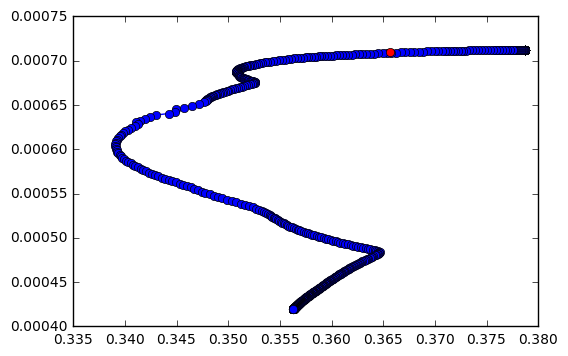

In [21]:
import matplotlib.pyplot as plt

sigma_opt = np.sqrt(np.dot(opt_port.T, np.dot(cov, opt_port)))
R_opt = np.dot(means, opt_port)

plt.plot(sigma, R, 'b-o')
plt.plot(sigma_opt, R_opt, 'ro')
plt.show()

In [22]:
request = 'asset?columns=ASSET_DATABASE_ID&columns=LABEL&columns=TYPE&TYPE=PORTFOLIO'
portfolio_id = int(server.get(request, ())[0]['ASSET_DATABASE_ID']['value'])

C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [23]:
portfolio_id

575

## Get all the assets' values and compute the quantities associated with each

In [48]:
c = CurrencyRates()
amounts = w
j = 0
r = 0
cotation_date = '2011-12-31'
cotation_date2 = '2012-02-01'
assets_dict = []
vals = np.zeros(p_m.sharpe_means_idx.shape[0])
q = np.zeros(p_m.sharpe_means_idx.shape[0])
for i in p_m.sharpe_means_idx:
    print(p_m.assets_ids[i])
    asset = server.get('asset/{}/quote?start_date={}&end_date={}', (p_m.assets_ids[i], cotation_date, cotation_date2))
    #m, curr = p_m.all_assets[p_m.assets_ids[i]]['LAST_CLOSE_VALUE']['value'].split()
    m = float(asset[0]['close'])
    #if curr != 'EUR':
    #    val = c.convert(curr,'EUR',float(m))
    #else:
    val = m
    vals[j] = val
    quantity = amounts[j] * money / val
    q[j] = int(quantity)
    print('div', amounts[j] * money / val)
    assets_dict.append({'asset': {'asset': int(p_m.assets_ids[i]), 'quantity': int(quantity)}})
    j += 1

306


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


div [ 1856.41818898]
352


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


div [ 2595.28927387]
8


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


div [ 2500.12116615]
516


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


div [ 9930.99462203]
147


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


div [ 13034.33127327]
433


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


div [ 271.14943638]
519


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


div [ 4406.56267008]
238


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


div [ 24002.27965953]
331


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


div [ 3294.40215019]
499


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


div [ 12004.61158268]
31


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


div [ 40816.18810231]
476


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


div [ 1813.51547834]
408


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


div [ 215.03418607]
308


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


div [ 1769.89942912]
421


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


div [ 1384.80620672]
402


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


div [ 1002.92290716]
422


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


div [ 68.98928363]
482


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


div [ 341.08616338]
111


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


div [ 43065.80533169]
549


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


div [ 694.36681783]


## Verification of the result
The result should be ~1e7. We have some precision loss because we discard the decimal values

In [49]:
q = np.array(q)
vals = np.array(vals)
np.sum(q * vals)

9996541.6899999995

In [25]:
potfolio_dict = {'currency': {'code': 'EUR'},'label': 'PORTFOLIO_USER7','type': 'front',
                 'values':{'2012-01-01':  assets_dict}}

In [26]:
print(potfolio_dict)

{'values': {'2012-01-01': [{'asset': {'asset': 306, 'quantity': 1856}}, {'asset': {'asset': 352, 'quantity': 2595}}, {'asset': {'asset': 8, 'quantity': 2500}}, {'asset': {'asset': 516, 'quantity': 9930}}, {'asset': {'asset': 147, 'quantity': 13034}}, {'asset': {'asset': 433, 'quantity': 271}}, {'asset': {'asset': 519, 'quantity': 4406}}, {'asset': {'asset': 238, 'quantity': 24002}}, {'asset': {'asset': 331, 'quantity': 3294}}, {'asset': {'asset': 499, 'quantity': 12004}}, {'asset': {'asset': 31, 'quantity': 40816}}, {'asset': {'asset': 476, 'quantity': 1813}}, {'asset': {'asset': 408, 'quantity': 215}}, {'asset': {'asset': 308, 'quantity': 1769}}, {'asset': {'asset': 421, 'quantity': 1384}}, {'asset': {'asset': 402, 'quantity': 1002}}, {'asset': {'asset': 422, 'quantity': 68}}, {'asset': {'asset': 482, 'quantity': 341}}, {'asset': {'asset': 111, 'quantity': 43065}}, {'asset': {'asset': 549, 'quantity': 694}}]}, 'type': 'front', 'label': 'PORTFOLIO_USER7', 'currency': {'code': 'EUR'}}


## Push the portfolio to the server

In [41]:
server.put("portfolio/{}/dyn_amount_compo", (portfolio_id), potfolio_dict)

req https://dolphin.jump-technology.com:3389/api/v1/portfolio/575/dyn_amount_compo


C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


''

## Verification that it was correctly pushed

In [37]:
server.get("portfolio/{}/dyn_amount_compo", (575))

C:\Users\cpcdoy\Anaconda3\lib\site-packages\requests\packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


{'currency': {'code': 'EUR'},
 'label': 'PORTFOLIO_USER7',
 'type': 'front',
 'values': {'2012-01-01': [{'asset': {'asset': 352, 'quantity': 2595.0}},
   {'asset': {'asset': 482, 'quantity': 341.0}},
   {'asset': {'asset': 516, 'quantity': 9930.0}},
   {'asset': {'asset': 421, 'quantity': 1384.0}},
   {'asset': {'asset': 549, 'quantity': 694.0}},
   {'asset': {'asset': 422, 'quantity': 68.0}},
   {'asset': {'asset': 519, 'quantity': 4406.0}},
   {'asset': {'asset': 8, 'quantity': 2500.0}},
   {'asset': {'asset': 331, 'quantity': 3294.0}},
   {'asset': {'asset': 238, 'quantity': 24002.0}},
   {'asset': {'asset': 111, 'quantity': 43065.0}},
   {'asset': {'asset': 433, 'quantity': 271.0}},
   {'asset': {'asset': 306, 'quantity': 1856.0}},
   {'asset': {'asset': 402, 'quantity': 1002.0}},
   {'asset': {'asset': 147, 'quantity': 13034.0}},
   {'asset': {'asset': 499, 'quantity': 12004.0}},
   {'asset': {'asset': 308, 'quantity': 1769.0}},
   {'asset': {'asset': 408, 'quantity': 215.0}},
   